# Define data to be used

In [10]:
import forex as fx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch
from torchdiffeq import odeint
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numba import njit
import scipy.optimize as opt
import numpy as np
import torch.nn as nn
import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D




_data = fx.min("EURUSD").data[0].to_numpy()
data = _data[:,2]


c:\Users\excal\Documents\GitHub\FinancialGamble\Forex\oanda\forex\utilities\_utils.py:54: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(pair, interval= "1m", period = "max",progress=False, ignore_tz=True).reset_index()


# Sim

In [114]:


@njit
def compute_accelerations(pos, masses, G, softening):
    n = len(masses)
    acc = np.zeros_like(pos)
    for i in range(n):
        for j in range(n):
            if i != j:
                dx = pos[j, 0] - pos[i, 0]
                dy = pos[j, 1] - pos[i, 1]
                dz = pos[j, 2] - pos[i, 2]
                r2 = dx*dx + dy*dy + dz*dz + softening*softening
                inv_r3 = 1.0 / (r2 * np.sqrt(r2))
                f = G * masses[j] * inv_r3
                acc[i, 0] += dx * f
                acc[i, 1] += dy * f
                acc[i, 2] += dz * f
    return acc

def sim(config, plot=False):
    G = config["G"]
    softening = config["softening"]
    initial_random_kick = config["initial_random_kick"]
    conserve_momentum = config["conserve_momentum"]
    make_barycenter_move = config["make_barycenter_move"]
    t_span = config["t_span"]
    t_eval = np.linspace(*t_span, config["dt"])

    bodies = config["bodies"]
    names = list(bodies.keys())
    n = len(names)
    masses = np.array([bodies[name]["mass"] for name in names])
    positions = np.array([bodies[name]["pos"] for name in names])

    # --- AUTO-CIRCULAR VELOCITY ---
    def compute_auto_velocities(positions, names, masses, G, jitter=0.02):
        n = len(names)
        vels = np.zeros_like(positions)
        central_idx = int(np.argmax(masses))
        M_central = masses[central_idx]
        pos_central = positions[central_idx]

        for i in range(n):
            if i == central_idx:
                continue
            r_vec = positions[i] - pos_central
            r = np.linalg.norm(r_vec) + 1e-12
            v_circ = np.sqrt(G * M_central / r)
            tangential = np.array([-r_vec[1], r_vec[0], 0.0])
            tangential /= np.linalg.norm(tangential)
            factor = 1.0 + jitter * (2.0 * (np.random.rand() - 0.5))
            vels[i] = tangential * v_circ * factor

        if initial_random_kick > 0.0:
            vels += initial_random_kick * np.random.randn(*vels.shape)
        return vels, central_idx

    velocities, central_idx = compute_auto_velocities(positions, names, masses, G, jitter=0.06)

    # --- APPLY CUSTOM VELOCITIES FROM CONFIG ---
    for i, name in enumerate(names):
        b = bodies[name]
        if "vel" in b:
            vel_vec = np.array(b["vel"], dtype=float)
            norm = np.linalg.norm(vel_vec)
            if norm < 1e-6:
                velocities[i] = np.zeros(3)
            elif norm < 2.0:  # treat as direction
                r_vec = positions[i] - positions[central_idx]
                r = np.linalg.norm(r_vec) + 1e-12
                v_circ = np.sqrt(G * masses[central_idx] / r)
                velocities[i] = (vel_vec / norm) * v_circ
            else:
                velocities[i] = vel_vec

    # --- MOMENTUM CONSERVATION ---
    total_momentum = (masses[:, None] * velocities).sum(axis=0)
    if conserve_momentum and not make_barycenter_move:
        velocities -= total_momentum / masses.sum()

    # --- Numba-Accelerated ODE Function ---
    def n_body_odes(t, y):
        pos = y[:3*n].reshape((n, 3))
        vel = y[3*n:].reshape((n, 3))
        acc = compute_accelerations(pos, masses, G, softening)
        return np.concatenate([vel.ravel(), acc.ravel()])

    # --- SOLVE ---
    y0 = np.concatenate([positions.ravel(), velocities.ravel()])


    sol = solve_ivp(
        n_body_odes, t_span, y0, t_eval=t_eval,
        rtol=1e-8, atol=1e-8, method='RK45'
    )

    pos_sol = sol.y[:3*n].reshape((n, 3, -1))
    centroid_pos = pos_sol[0]
    distances_from_first = np.linalg.norm(pos_sol - centroid_pos[None, :, :], axis=1)

    # --- PLOT ---
    if plot:
        plt.figure(figsize=(9, 9))
        for i, name in enumerate(names):
            plt.plot(pos_sol[i, 0, :], pos_sol[i, 1, :], label=name, linewidth=0.9)
            plt.scatter(pos_sol[i, 0, 0], pos_sol[i, 1, 0], s=40)
        plt.title("N-body Trajectories")
        plt.xlabel("x"); plt.ylabel("y")
        plt.axis('equal'); plt.grid(True)
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 4))
        for i, name in enumerate(names):
            plt.plot(sol.t, distances_from_first[i], label=f"{name} | dist from first")
        plt.xlabel("time"); plt.ylabel("Distance from first planet")
        plt.grid(True)
        plt.legend()
        plt.show()

    return pos_sol, distances_from_first, names


# Optimizer Minimizer

In [ ]:


def objective_function(x):
    assert len(x) 
    config = {
        "G": 1.0,
        "softening": 0.05,
        "initial_random_kick": 0.0,
        "conserve_momentum": True,
        "make_barycenter_move": True,
        "t_span": (0, 40),
        "dt": 14,
        "bodies": {
            "B": {"mass": 100.0, "pos": np.array([0.0, 0.0, 0.0])},
            "A": {"mass": x[0], "pos": np.array([x[2], x[3], x[4]]), "vel": np.array([x[5], x[6], x[7]])},
            "C": {"mass": x[1], "pos": np.array([x[8], x[9], x[10]]), "vel": np.array([x[11], x[12], x[13]])},
            "D": {"mass": x[1], "pos": np.array([x[8], x[9], x[10]]), "vel": np.array([x[11], x[12], x[13]])},
        }
    }
    positions, distances, names = sim(config, plot=False)
    mse_loss_fn = nn.MSELoss()
    # Reduce to scalar error (sum of squared differences)
    # return distances, mse_loss_fn(torch.tensor(distances[1,:]), data[:config["dt"]])
    return mse_loss_fn(torch.tensor(distances[1,:]), torch.tensor(data[:config["dt"]])).numpy()
    # return 1

initial_guess = np.random.randn(14)
initial_guess[0] = 1
initial_guess[1] = 1

result = opt.minimize(objective_function, initial_guess, method='BFGS', options={"maxiter": 10, "disp" : True})

# print("Optimization Result:")
# print(f"Success: {result.success}")
# print(f"Message: {result.message}")
# print(f"Optimal x values: {result.x}")
# print(f"Minimum function value: {result.fun}")


# Redefine Sim to accept torch arrays

In [76]:
import torch
from torchdiffeq import odeint
import matplotlib.pyplot as plt

def sim_torch(x, t_span=(0, 28), dt=28, G=1.0, softening=0.05, normalize=True, plot=False):
    """
    Differentiable N-body simulator in 3D with optional [0,1] normalization and plotting.
    """
    n_bodies = x.shape[0] // 7
    # print(n_bodies)

    # Extract masses, positions, velocities
    masses = torch.abs(x[::7])
    pos_list = [x[7*i + 1 : 7*i + 4] for i in range(n_bodies)]
    vel_list = [x[7*i + 4 : 7*i + 7] for i in range(n_bodies)]

    pos0 = torch.stack(pos_list, dim=0)
    vel0 = torch.stack(vel_list, dim=0)

    y0 = torch.cat([pos0.flatten(), vel0.flatten()])
    t_eval = torch.linspace(t_span[0], t_span[1], dt)

    def n_body_odes(t, y):
        pos = y[:3*n_bodies].reshape(n_bodies, 3)
        vel = y[3*n_bodies:].reshape(n_bodies, 3)

        acc = torch.zeros_like(pos)
        for i in range(n_bodies):
            for j in range(n_bodies):
                if i != j:
                    r_vec = pos[j] - pos[i]
                    r = torch.norm(r_vec) + softening
                    acc[i] += G * masses[j] * r_vec / r**3

        return torch.cat([vel.flatten(), acc.flatten()])

    sol = odeint(n_body_odes, y0, t_eval)

    pos_sol = sol[:, :3*n_bodies].reshape(dt, n_bodies, 3).permute(1, 2, 0)  # (n_bodies, 3, dt)
    centroid_pos = pos_sol[0]
    distances = torch.norm(pos_sol - centroid_pos[None, :, :], dim=1)

    # Normalize to [0,1] if requested
    if normalize:
        min_val = pos_sol.min()
        max_val = pos_sol.max()
        pos_sol = (pos_sol - min_val) / (max_val - min_val + 1e-8)

        min_dist = distances.min()
        max_dist = distances.max()
        distances = (distances - min_dist) / (max_dist - min_dist + 1e-8)

    # Plot if requested
    if plot:
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111, projection='3d')
        for i in range(n_bodies):
            ax.plot(pos_sol[i,0,:].cpu().numpy(),
                    pos_sol[i,1,:].cpu().numpy(),
                    pos_sol[i,2,:].cpu().numpy(), label=f'Body {i+1}')
            ax.scatter(pos_sol[i,0,0].cpu().numpy(),
                       pos_sol[i,1,0].cpu().numpy(),
                       pos_sol[i,2,0].cpu().numpy(), marker='o')  # start
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title('N-body Simulation Trajectories')
        ax.legend()
        plt.show()

    return pos_sol, distances, masses


# Physics Informend Neural Netowrk

In [92]:
softening = 0.05
G = 1.0

# -------------------------------
# PINN Acceleration
# -------------------------------

class PINN_Acceleration(nn.Module):
    def __init__(self, n_bodies, G=1.0, softening=0.05):
        super().__init__()
        self.n_bodies = n_bodies
        self.G = G
        self.softening = softening

        # Neural network correction term
        self.net = nn.Sequential(
            nn.Linear(n_bodies * 7, 64),
            nn.Tanh(),
            nn.Linear(64, n_bodies * 7)
        )

    def forward(self, x):
        """
        x: (n_bodies * 7,) flattened tensor
        Format per body: [mass, pos_x, pos_y, pos_z, vel_x, vel_y, vel_z, ...]

        Returns:
            (n_bodies, 3) accelerations
        """

        pos = x
        # n_bodies = x.shape[0] // 7
        # masses = torch.abs(x[::7])  # every 7th element: 0, 7, 14, ...
        # pos = torch.stack([x[7*i + 1 : 7*i + 4] for i in range(n_bodies)])  # (n_bodies, 3)

        # a_phys = torch.zeros_like(pos)

        # --- Softened Newtonian gravity ---
        # for i in range(n_bodies):
        #     for j in range(n_bodies):
        #         if i != j:
        #             r_vec = pos[j] - pos[i]             # vector from i to j
        #             r2 = torch.sum(r_vec**2) + self.softening**2
        #             inv_r3 = torch.pow(r2, -1.5)
        #             a_phys[i] += self.G * masses[j] * r_vec * inv_r3

        # --- Neural network correction ---
        # print(pos.shape)
        a_nn = self.net(pos.flatten())

        # --- Total acceleration ---
        return  a_nn


    



# -------------------------------
# ODE function for PINN
# -------------------------------
def pinn_nbody_odes(t, y, nn_model, n_bodies, masses):
    pos = y[:3*n_bodies].reshape(n_bodies, 3)
    vel = y[3*n_bodies:].reshape(n_bodies, 3)
    acc = nn_model(pos, masses)
    dydt = torch.cat([vel.flatten(), acc.flatten()])
    return dydt

# -------------------------------
# nn_odeint wrapper
# -------------------------------
def nn_odeint(x, nn_model, t_span=(0,28), dt=28):
    n_bodies = x.shape[0] // 7
    masses = torch.abs(x[::7])

    pos_list = [x[7*i+1:7*i+4] for i in range(n_bodies)]
    pos0 = torch.stack(pos_list, dim=0)
    vel_list = [x[7*i+4:7*i+7] for i in range(n_bodies)]
    vel0 = torch.stack(vel_list, dim=0)

    y0 = torch.cat([pos0.flatten(), vel0.flatten()])
    t_eval = torch.linspace(t_span[0], t_span[1], dt)

    sol = odeint(lambda t, y: pinn_nbody_odes(t, y, nn_model, n_bodies, masses),
                 y0, t_eval, method='dopri5')

    pos_sol = sol[:, :3*n_bodies].reshape(dt, n_bodies, 3).permute(1,2,0)
    vel_sol = sol[:, 3*n_bodies:].reshape(dt, n_bodies, 3).permute(1,2,0)
    distances = torch.norm(pos_sol - pos_sol[:, :, 0:1], dim=1)
    accelerations = nn_model(pos_sol[:, :, -1], masses)
    return pos_sol, vel_sol, distances, accelerations

# Implimentation and Train loop of PINN


In [ ]:
import torch
import torch.nn as nn
from torchdiffeq import odeint
import tqdm
import matplotlib.pyplot as plt

# -------------------------------
# Physics-based simulator (reference)
# -------------------------------
# def sim_torch(x, t_span=(0,28), dt=28, G=1.0, softening=0.05):
#     n_bodies = x.shape[0] // 7

#     masses = torch.abs(x[::7])
#     pos_list = [x[7*i+1:7*i+4] for i in range(n_bodies)]
#     vel_list = [x[7*i+4:7*i+7] for i in range(n_bodies)]
#     pos0 = torch.stack(pos_list)
#     vel0 = torch.stack(vel_list)

#     y0 = torch.cat([pos0.flatten(), vel0.flatten()])
#     t_eval = torch.linspace(t_span[0], t_span[1], dt)

#     def n_body_odes(t, y):
#         pos = y[:3*n_bodies].reshape(n_bodies, 3)
#         vel = y[3*n_bodies:].reshape(n_bodies, 3)
#         acc = torch.zeros_like(pos)

#         # softened Newtonian gravity
#         for i in range(n_bodies):
#             r_vec = pos - pos[i]
#             r2 = (r_vec**2).sum(dim=1) + softening**2
#             inv_r3 = torch.pow(r2, -1.5)
#             acc[i] += (G * (masses[:, None] * r_vec * inv_r3[:, None]).sum(dim=0)) - \
#                       (G * masses[i] * 0)  # exclude self-force
#         dydt = torch.cat([vel.flatten(), acc.flatten()])
#         return dydt

#     sol = odeint(n_body_odes, y0, t_eval)
#     pos_sol = sol[:, :3*n_bodies].reshape(dt, n_bodies, 3).permute(1, 2, 0)
#     centroid = pos_sol[0]
#     distances = torch.norm(pos_sol - centroid[None, :, :], dim=1)
#     return pos_sol, distances, masses

# -------------------------------
# PINN acceleration (vectorized)
# -------------------------------
class PINN_Acceleration(nn.Module):
    def __init__(self, n_bodies, G=1.0, softening=0.05):
        super().__init__()
        self.n_bodies = n_bodies
        self.G = G
        self.softening = softening

        self.net = nn.Sequential(
            nn.Linear(n_bodies * 3, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, n_bodies * 3)
        )

    def forward(self, pos, masses):
        n = self.n_bodies
        diff = pos[None, :, :] - pos[:, None, :]  # (n, n, 3)
        r2 = (diff**2).sum(dim=2) + self.softening**2  # (n, n)
        inv_r3 = torch.pow(r2, -1.5)
        acc = self.G * (masses[None, :, None] * diff * inv_r3[:, :, None]).sum(dim=1)
        a_nn = self.net(pos.flatten()).reshape(n, 3)
        return acc + a_nn

# -------------------------------
# ODE dynamics for PINN
# -------------------------------
def pinn_nbody_odes(t, y, nn_model, n_bodies, masses):
    pos = y[:3*n_bodies].reshape(n_bodies, 3)
    vel = y[3*n_bodies:].reshape(n_bodies, 3)
    acc = nn_model(pos, masses)
    dydt = torch.cat([vel.flatten(), acc.flatten()])
    return dydt

def nn_odeint(x, nn_model, t_span=(0,28), dt=28):
    n_bodies = x.shape[0] // 7
    masses = torch.abs(x[::7])

    pos_list = [x[7*i+1:7*i+4] for i in range(n_bodies)]
    vel_list = [x[7*i+4:7*i+7] for i in range(n_bodies)]
    pos0 = torch.stack(pos_list)
    vel0 = torch.stack(vel_list)
    y0 = torch.cat([pos0.flatten(), vel0.flatten()])

    t_eval = torch.linspace(t_span[0], t_span[1], dt)
    sol = odeint(lambda t,y: pinn_nbody_odes(t, y, nn_model, n_bodies, masses),
                 y0, t_eval, method='dopri5')

    pos_sol = sol[:, :3*n_bodies].reshape(dt, n_bodies, 3).permute(1,2,0)
    vel_sol = sol[:, 3*n_bodies:].reshape(dt, n_bodies, 3).permute(1,2,0)
    centroid = pos_sol[0]
    distances = torch.norm(pos_sol - centroid[None, :, :], dim=1)
    accelerations = nn_model(pos_sol[:, :, -1], masses)
    return pos_sol, vel_sol, distances, accelerations

# -------------------------------
# Training setup
# -------------------------------
dt = 28
t_span = (0, 200)
n_bodies = 3
x = torch.zeros(n_bodies*7)

# central body
x[0] = 10.0
x[1:4] = 0.0
x[4:7] = 0.0

# moving bodies
for i in range(1, 3):
    idx = i*7
    x[idx] = 1.0
    x[idx+1:idx+4] = torch.randn(3) * 5.0
    x[idx+4:idx+7] = torch.randn(3) * 0.1

pos_actual, ref_distances, masses = sim_torch(x, t_span, dt)
x.requires_grad_()

# -------------------------------
# Train PINN model
# -------------------------------
nn_model = PINN_Acceleration(n_bodies)
optimizer = torch.optim.Adam(list(nn_model.parameters()), lr=1e-3)
loss_fn = nn.MSELoss()

epochs = 500
loss_arr = []

# for epoch in tqdm.tqdm(range(epochs)):
#     optimizer.zero_grad()

    

#     # Forward through PINN
#     pos_sol, vel_sol, distances, acc = nn_odeint(x, nn_model, t_span, dt)
#     pos_sol = torch.nan_to_num(pos_sol, nan=0.0, posinf=1e3, neginf=-1e3)
#     vel_sol = torch.clamp(vel_sol, -1e3, 1e3)
#     # Compute loss
#     loss = loss_fn(distances, ref_distances)
#     loss_arr.append(loss.item())

#     if epoch % 10 == 0:
#         # Randomize every 10 epochs 
#         # x = torch.zeros(n_bodies*7)
#         # x[0] = 10.0  # center body
#         # x[1:4] = 0.0
#         # x[4:7] = 0.0
#         # for i in range(1, n_bodies):
#         #     idx = i * 7
#         #     x[idx] = 1.0
#         #     x[idx+1:idx+4] = torch.randn(3) * 5.0
#         #     x[idx+4:idx+7] = torch.randn(3) * 0.2

#         # Simulate ground truth for these initial conditions
#         pos_actual, ref_distances, masses = sim_torch(x, t_span, dt)
#         print(f"Loss : {loss.item()}")

#     loss.backward()
#     optimizer.step()


# -------------------------------
# Plot trajectories
# -------------------------------
def plot_trajectories(pos_sol, title="Trajectories"):
    n_bodies = pos_sol.shape[0]
    colors = ['r','b','g','c','m','y']
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(n_bodies):
        ax.plot(pos_sol[i,0,:].detach().numpy(),
                pos_sol[i,1,:].detach().numpy(),
                pos_sol[i,2,:].detach().numpy(),
                color=colors[i%6], label=f'Body {i}')
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title(title)
    ax.legend()
    plt.show()

plot_trajectories(pos_actual, title="Actual Physics Trajectories")
plot_trajectories(pos_sol, title="Trained PINN Trajectories")
plt.plot(loss_arr)
plt.title("Loss Array")
plt.show()


Text(0.5, 1.0, 'Estimate')

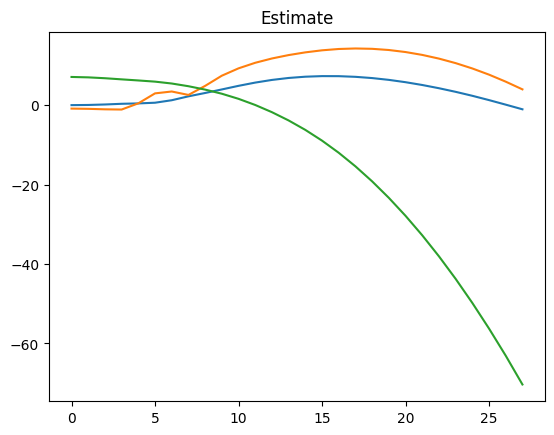

In [16]:


x = torch.zeros(3*7, dtype=torch.float32)

# Center body: fixed at origin, mass = 10
x[0] = 10.0  # mass
x[1:4] = 0.0  # pos
x[4:7] = 0.0  # vel

# Moving bodies: random initial guess
for i in range(1, 3):
    idx = i*7
    x[idx] = 1.0  # mass = 1
    x[idx+1:idx+4] = torch.randn(3) * 5.0  # random pos
    x[idx+4:idx+7] = torch.randn(3) * 0.1  # small random vel

# Reference distances (fake for demo, replace with actual if available)


posititons_stuff, vel_stuff, _distances, accelerations_stuff = nn_odeint(x, nn_model, t_span, dt)

# Reference distances (fake for demo, replace with actual if available)
# pos_actual, reference_distances, masses = sim_torch(x.detach(), t_span, dt) 

plt.plot(posititons_stuff[:,2].detach().numpy().T)
plt.title("Estimate")

# Machine Learning for Solving IVP of N body problem matching data

In [111]:
# Example: 2 bodies (A,B) + Center
n_bodies = 5
n_per_body = 7
dt = 128
t_span = (0, 64)


model = PINN_Acceleration(n_bodies=n_bodies)

x = torch.randn(n_bodies * n_per_body, dtype=torch.float32, requires_grad=True)


# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = F.mse_loss
loss_arr = []

epochs = 1000

best_distances = 0
best_loss = 999

for epoch in tqdm.tqdm(range(epochs)):
    optimizer.zero_grad()

    # Build config from current parameters

    f = model(x)
    # Run differentiable simulation
    _, distances, _ = sim_torch(f.flatten(), t_span=t_span, dt=dt)
    y = torch.tensor(data[:len(distances[1])], dtype=torch.float32)
    # print(distances[1].shape, y.shape)
    # Loss: MSE on distances of body 1 vs reference
    loss = loss_fn(distances[1], y)

    if loss < best_loss:
        best_loss = loss.item()
        best_distances = distances

    # Backprop and step
    loss.backward()
    optimizer.step()

    loss_arr.append(loss.item())

    if epoch% 30 == 0:
        x = torch.randn(n_bodies * n_per_body, dtype=torch.float32, requires_grad=True)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {loss.item():.6f}")


  0%|          | 1/1000 [01:14<20:36:23, 74.26s/it]

Epoch 1/1000 | Loss: 0.716804


  0%|          | 3/1000 [06:32<36:14:07, 130.84s/it]


KeyboardInterrupt: 

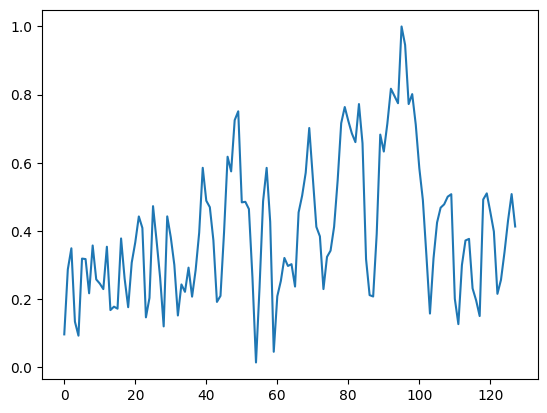

In [112]:
plt.plot(distances[1].detach().T)


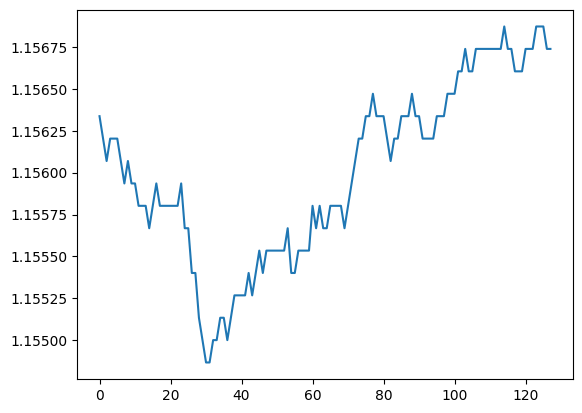

In [113]:
plt.plot(data[:len(distances[1])])

3


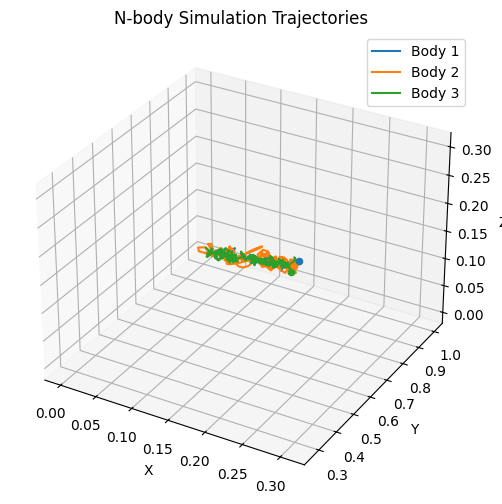

(tensor([[[0.3088, 0.3044, 0.2964,  ..., 0.0149, 0.0082, 0.0058],
          [0.2727, 0.2843, 0.2849,  ..., 0.9902, 0.9976, 0.9935],
          [0.3029, 0.2944, 0.2766,  ..., 0.0098, 0.0013, 0.0053]],
 
         [[0.2992, 0.2980, 0.2976,  ..., 0.0000, 0.0063, 0.0142],
          [0.2881, 0.2780, 0.2873,  ..., 0.9700, 0.9845, 0.9939],
          [0.2868, 0.2842, 0.2977,  ..., 0.0195, 0.0183, 0.0023]],
 
         [[0.2991, 0.2986, 0.3023,  ..., 0.0156, 0.0132, 0.0041],
          [0.2750, 0.2836, 0.2933,  ..., 0.9868, 0.9845, 1.0000],
          [0.2804, 0.2865, 0.2936,  ..., 0.0086, 0.0136, 0.0126]]]),
 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0

In [110]:
nn_output = f.flatten()

print(nn_output.shape[0] // 7)

sim_torch(nn_output.detach(), t_span=t_span, dt=dt, plot=True)